In [2]:
import pandas as pd
import numpy as np
import json
from pprint import pprint
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path

In [3]:
versions = {
    "3.9.10":False,
    "nogil-3.9.10-1_0":False,
    "nogil-3.9.10-1_1":False,
    "3.9.18":False,
    "3.10.13":False,
    "3.11.8":False,
    "3.12.2":False,
}

In [173]:
if os.path.exists("./versions.json"):
    with open("./versions.json","r") as f:
        versions = json.load(f)
        print("loaded")
else:
    with open("./versions.json","w") as f:
        versions_json = json.dumps(versions, indent=4)
        f.write(versions_json)
        print("dumped")

dumped


In [174]:
# Metodo che controlla che ogni versione specificata sia installata sul sistema. 
# Se non lo è la installa, e se il processo di installazione fallisce skippa 
# quella versione rimuovendola dall'elenco di versioni da testare.

def check_versions(versions):
    #print(versions)
    temp = versions.copy()
    for version in temp.keys():
        if not os.path.exists(f"{os.environ['HOME']}/.pyenv/versions/{version}"):
            res = subprocess.run(f"env PYTHON_CONFIGURE_OPTS='--enable-optimizations --with-lto' pyenv install {version}", shell=True)
            if res.returncode != 0:
                versions.pop(version)

In [175]:
check_versions(versions)

In [167]:
# Inizia a raccogliere dati con pyperformance
subprocess.run("pyperf system tune", shell=True)

for version,done in versions.items():
    if done:
        continue
    subprocess.run(f"pyperformance run --python={os.environ['HOME']}/.pyenv/versions/{version}/bin/python -o ./pyperf_res/{version}.json", shell=True)
    versions[version] = True
    with open("./versions.json","w") as f:
        versions_json = json.dumps(versions, indent=4)
        f.write(versions_json)

subprocess.run("pyperf system reset", shell=True)

In [146]:
# Processed files (no warmups)

In [14]:
path = '../results_to_analyse/2024_05_10-19_10_14/single_thread/'
files_to_process = []
for file_name in os.listdir(path):
    if file_name.endswith('.json'):
        print(file_name)
        files_to_process.append(file_name)

3.10.13.json
3.12.2.json
nogil-3.9.10-1_0.json
nogil-3.9.10-1_1.json
3.9.18.json
3.11.8.json
3.9.10.json


In [15]:
for file in files_to_process:
    f = open(path+file)
    data = json.load(f)
    benchmarks = {}
    for d in data['benchmarks']:
        benchmarks[d['metadata']['name']] = d['runs'][1:]
    for key,val in benchmarks.items():
        for v in val:
            v.pop('warmups')
    json_benchmarks = json.dumps(benchmarks, indent=4)

    new_path = Path(f"{path}processed/")
    new_path.mkdir(parents=True, exist_ok=True)
    # Writing to sample.json
    with open(f"{path}processed/{file.replace('.json','')}_processed.json", "w") as outfile:
        outfile.write(json_benchmarks)

In [16]:
# Create dataframe from processed files

In [17]:
columns = {
    '3.10.13_processed.json':'3.10.13',
    '3.11.8_processed.json':'3.11.8',
    '3.12.2_processed.json':'3.12.2',
    '3.9.18_processed.json':'3.9.18',
    '3.9.10_processed.json':'3.9.10',
    'nogil-3.9.10-1_0_processed.json':'nogil-3.9.10_0',
    'nogil-3.9.10-1_1_processed.json':'nogil-3.9.10_1'
}

In [18]:
path = '../results_to_analyse/2024_05_10-19_10_14/single_thread/processed/'
files = []
for file_name in os.listdir(path):
    if file_name.endswith('.json'):
        print(file_name)
        files.append(file_name)

3.9.10_processed.json
3.9.18_processed.json
nogil-3.9.10-1_1_processed.json
3.10.13_processed.json
nogil-3.9.10-1_0_processed.json
3.11.8_processed.json
3.12.2_processed.json


In [19]:
# Get complete list of benchmarks
benchmarks = []
for file in sorted(files):
    f = open(path+file)
    data = json.load(f)
    benchmarks.extend(data.keys())
benchmarks = sorted(list(set(benchmarks)))

In [20]:
df = {}
df['Benchmarks'] = benchmarks

In [21]:
for file in sorted(files):
    print(file)
    all_times = []
    f = open(path+file)
    data = json.load(f)
    for key in benchmarks:
        if data.get(key):
            bench = data[key]
            #pp(bench)
            times = []
            for run in bench:
                vals = run['values']
                times.extend(vals)
            #print(times)
            avg_time = np.average(times)
            all_times.append(round(avg_time,5))
        else:
            all_times.append(np.nan)
    df[columns[file].replace('.json','')] = all_times

3.10.13_processed.json
3.11.8_processed.json
3.12.2_processed.json
3.9.10_processed.json
3.9.18_processed.json
nogil-3.9.10-1_0_processed.json
nogil-3.9.10-1_1_processed.json


In [22]:
pd.set_option('display.max_rows', 500)

In [23]:
times_df = pd.DataFrame(df)
columns = [
    'Benchmarks',
    '3.9.10',
    'nogil-3.9.10_0',
    'nogil-3.9.10_1',
    '3.9.18',
    '3.10.13',
    '3.11.8',
    '3.12.2'
]
times_df = times_df[columns]
times_df_notnull = times_df.dropna()
times_df_notnull.reset_index(inplace=True, drop = True)
times_df = times_df_notnull
times_df

,Benchmarks,3.9.10,nogil-3.9.10_0,nogil-3.9.10_1,3.9.18,3.10.13,3.11.8,3.12.2
0,2to3,0.48321,0.51300,0.51236,0.48141,0.37051,0.29028,0.33476
1,async_generators,0.64639,0.75852,0.75858,0.64132,0.50966,0.41509,0.61450
2,async_tree_cpu_io_mixed,1.43713,0.89827,0.89082,1.43036,1.14467,0.94344,0.88524
3,async_tree_eager,1.03825,0.54025,0.53574,1.02892,0.84867,0.61443,0.15097
4,async_tree_eager_cpu_io_mixed,1.43795,0.89647,0.89080,1.43048,1.17404,0.94584,0.48808
5,async_tree_eager_io,2.44407,1.15261,1.14002,2.43697,2.00323,1.42258,1.53000
6,async_tree_eager_memoization,1.26343,0.66385,0.65685,1.24942,1.04459,0.73627,0.33151
7,async_tree_io,2.44409,1.15183,1.14556,2.43540,2.00195,1.42740,1.36964
8,async_tree_memoization,1.26522,0.66270,0.65759,1.25019,1.03293,0.73310,0.73953
9,async_tree_none,1.04116,0.54019,0.53525,1.03047,0.84664,0.61641,0.59254


In [24]:
times = []
for col in times_df.columns[1:]:
    avg_time = np.average(times_df[col])
    times.append(avg_time)

In [25]:
_2darray = []
row_list = []
for idx, row in times_df.iterrows():
    row_list.append(list(row))
    if len(row_list) == 10:
        _2darray.append(row_list)
        row_list = []

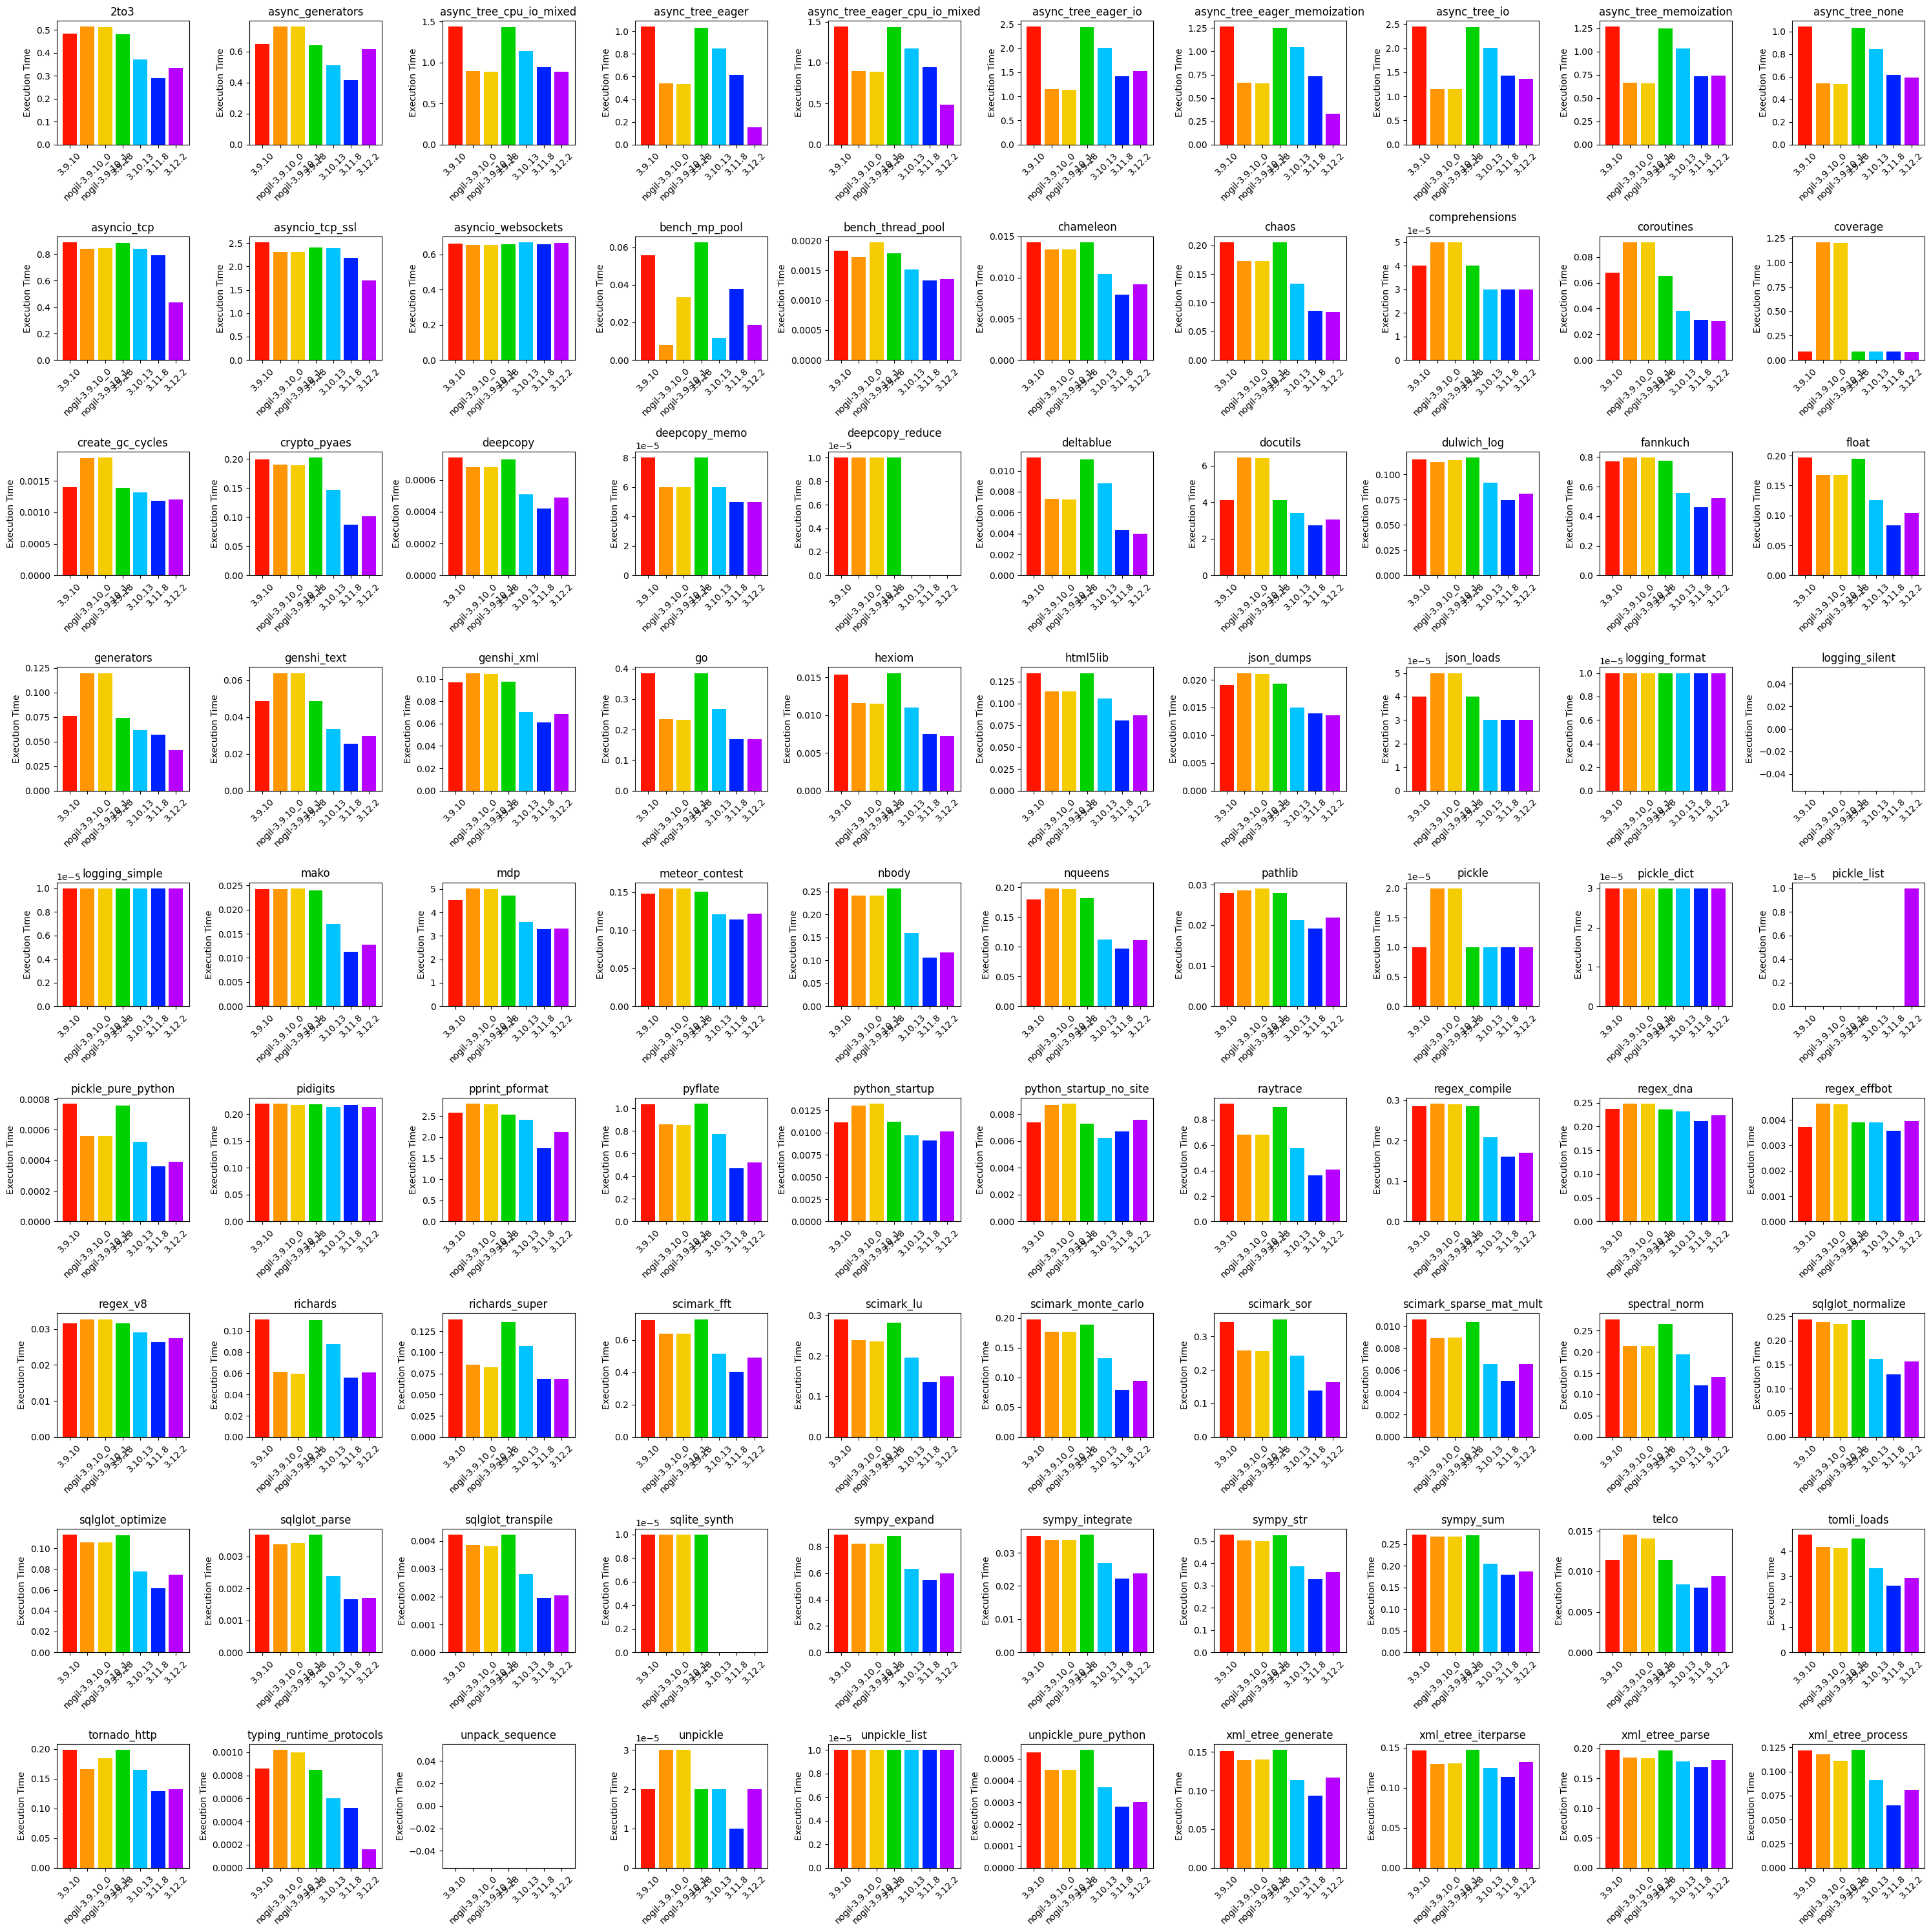

In [26]:
fig, axes = plt.subplots(nrows=9, ncols=10, figsize=(30, 30))

# Loop through each row in the DataFrame
for i in range(10):
    for j in range(9):
        # Create a bar plot for the current benchmark in the corresponding subplot
        ax = axes[j,i]
        benchmark_name = _2darray[j][i][0]  # Extract benchmark name from DataFrame
        benchmark_data = _2darray[j][i][1:]    # Extract benchmark data from DataFrame
        labels = list(times_df.columns)[1:]
        colors = ["#ff1500","#ff9602","#f5cc02","#00d200","#00c3ff","#0022ff","#b700ff"]
        colors = [colors[i] for i in range(len(colors)) if i < len(times_df.columns[1:])]
        #colors.reverse()
        for k, color in enumerate(colors):
            ax.bar(k, benchmark_data[k], color=color)
        ax.set_title(benchmark_name)
        ax.set_ylabel("Execution Time")
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
plt.tight_layout()
plt.savefig(f"../results_to_analyse/2024_05_10-19_10_14/single_thread/grafici/all_benchmarks.png", bbox_inches='tight' ,transparent=False, pad_inches=1)
plt.show()

In [41]:
# Processed files (no warmups)

In [27]:
path = '../results_to_analyse/2024_05_10-19_10_14/memory_single_thread/'
files_to_process = []
for file_name in os.listdir(path):
    if file_name.endswith('.json'):
        files_to_process.append(file_name)

In [28]:
processed_files = {}
for file in files_to_process:
    f = open(path + file)
    data = json.load(f)
    benchmarks = {}
    for d in data['benchmarks']:
        benchmarks[d['metadata']['name']] = d['runs'][1:]
    processed_files[f"{file.replace('.json', '')}_processed.json"] = benchmarks

In [29]:
# Create dataframe from processed files

In [30]:
benchmarks = []
for file in sorted(processed_files):
    benchmarks.extend(processed_files[file].keys())
benchmarks = sorted(list(set(benchmarks)))

In [31]:
df = {}
df['Benchmarks'] = benchmarks

In [32]:
columns = {
    '3.10.13_processed.json':'3.10.13',
    '3.11.8_processed.json':'3.11.8',
    '3.12.2_processed.json':'3.12.2',
    '3.9.18_processed.json':'3.9.18',
    '3.9.10_processed.json':'3.9.10',
    'nogil-3.9.10-1_0_processed.json':'nogil-3.9.10_0',
    'nogil-3.9.10-1_1_processed.json':'nogil-3.9.10_1'
}

In [33]:
for file in sorted(processed_files):
        all_mems = []
        data = processed_files[file]
        for key in benchmarks:
            if data.get(key):
                bench = data[key]
                mems = []
                for run in bench:
                    vals = run['values']
                    mems.extend(vals)
                # print(times)
                avg_mem = np.average(mems)
                avg_mem = avg_mem/1024/1024
                all_mems.append(round(avg_mem, 1))
            else:
                all_mems.append(np.nan)
        df[columns[file].replace('.json', '')] = all_mems

In [34]:
pd.set_option('display.max_rows', 500)

In [35]:
mems_df = pd.DataFrame(df)
columns = [
    'Benchmarks',
    '3.9.10',
    'nogil-3.9.10_0',
    'nogil-3.9.10_1',
    '3.9.18',
    '3.10.13',
    '3.11.8',
    '3.12.2'
]
mems_df = mems_df[columns]
mems_df_notnull = mems_df.dropna()
mems_df_notnull.reset_index(inplace=True, drop=True)
mems_df = mems_df_notnull
mems_df

,Benchmarks,3.9.10,nogil-3.9.10_0,nogil-3.9.10_1,3.9.18,3.10.13,3.11.8,3.12.2
0,2to3,22.3,41.4,41.4,22.3,21.5,23.7,24.8
1,async_generators,30.0,61.9,61.8,30.0,29.9,26.0,25.2
2,async_tree_cpu_io_mixed,92.1,225.7,225.7,92.2,77.9,78.2,71.3
3,async_tree_io,193.0,765.8,765.7,192.8,178.7,68.6,61.5
4,async_tree_memoization,77.1,246.3,237.8,74.2,96.9,78.5,73.2
5,async_tree_none,89.2,209.8,205.7,89.0,81.9,55.9,52.0
6,asyncio_tcp,47.0,86.2,92.3,44.8,48.0,44.9,39.3
7,asyncio_tcp_ssl,68.3,137.4,140.6,71.6,68.3,73.1,62.9
8,asyncio_websockets,50.2,95.3,92.9,49.8,51.0,52.3,52.0
9,bench_mp_pool,8.4,34.7,30.7,8.4,8.3,9.7,9.7


In [36]:
_2darray = []
row_list = []
for idx, row in mems_df.iterrows():
    row_list.append(list(row))
    if (idx!=85 and len(row_list) == 10) or idx==85:
        _2darray.append(row_list)
        row_list = []

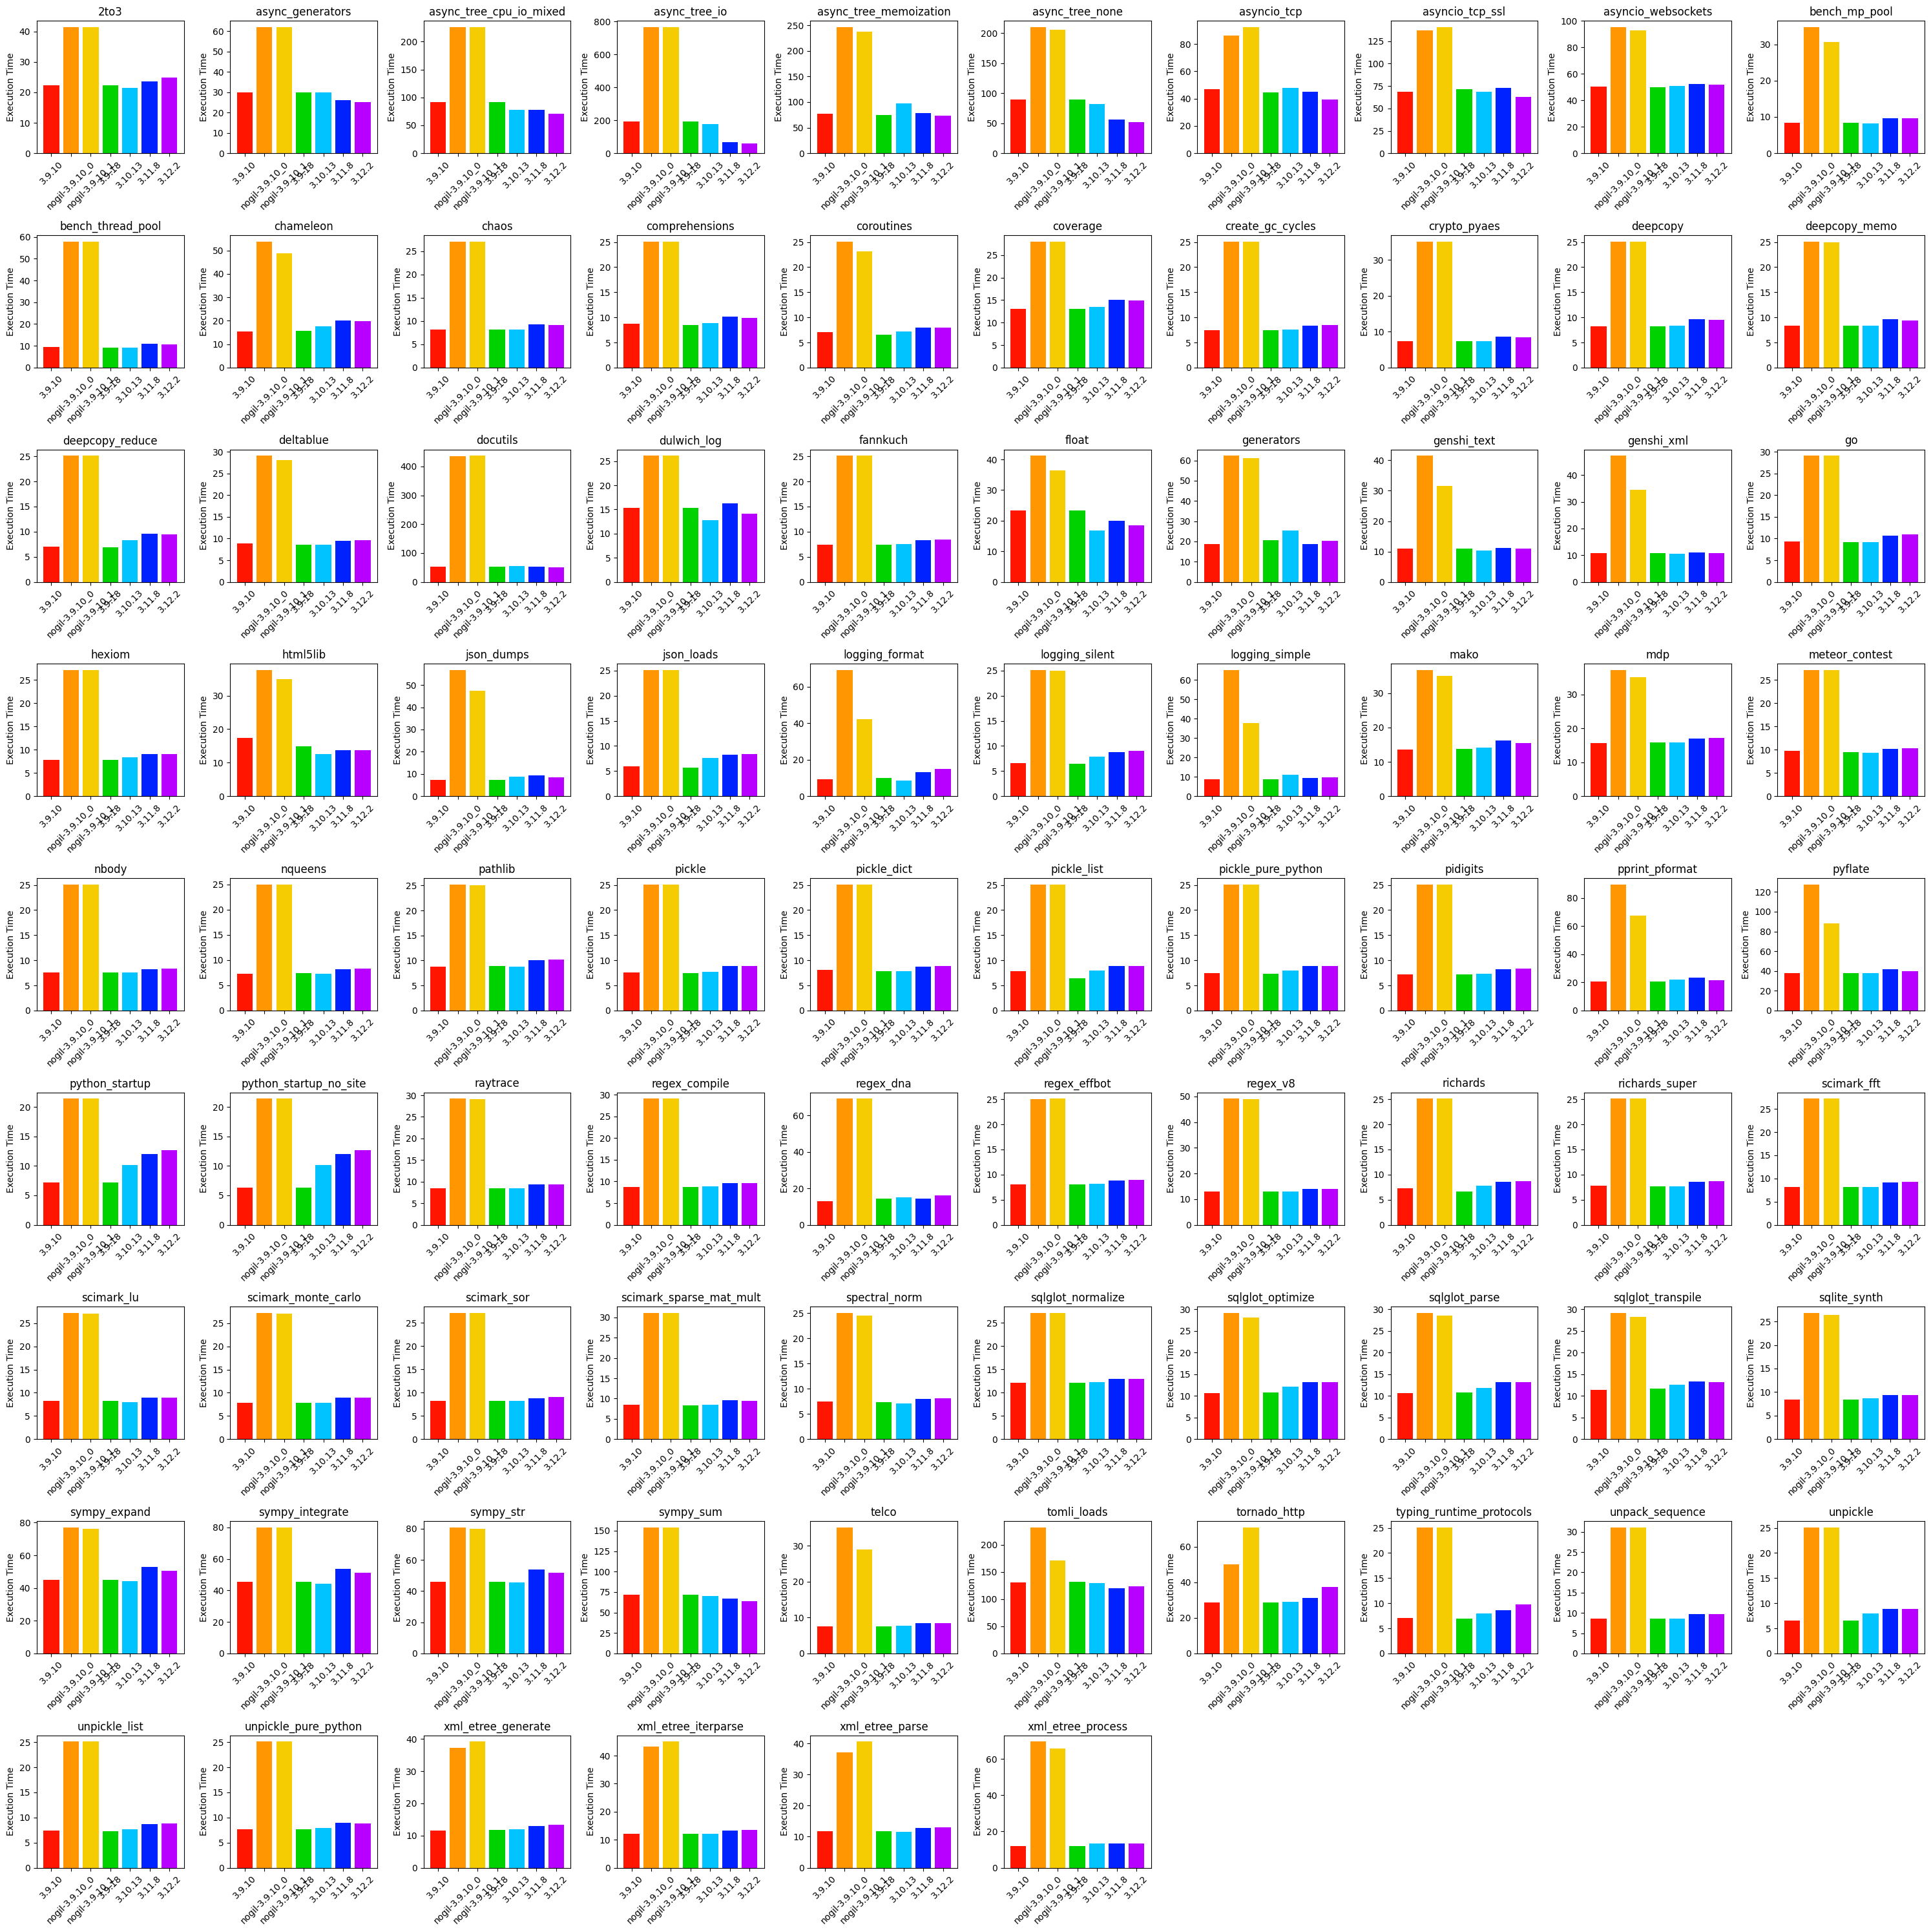

In [37]:
fig, axes = plt.subplots(nrows=9, ncols=10, figsize=(30, 30))

# Loop through each row in the DataFrame
for i in range(10):
    for j in range(9):
        if j==8 and i>5:
            ax = axes[j,i]
            ax.set_visible(False)
        else:
            ax = axes[j,i]
            # Create a bar plot for the current benchmark in the corresponding subplot
            benchmark_name = _2darray[j][i][0]  # Extract benchmark name from DataFrame
            benchmark_data = _2darray[j][i][1:]    # Extract benchmark data from DataFrame
            labels = list(mems_df.columns)[1:]
            colors = ["#ff1500","#ff9602","#f5cc02","#00d200","#00c3ff","#0022ff","#b700ff"]
            colors = [colors[i] for i in range(len(colors)) if i < len(times_df.columns[1:])]
            for k, color in enumerate(colors):
                ax.bar(k, benchmark_data[k], color=color)
            ax.set_title(benchmark_name)
            ax.set_ylabel("Execution Time")
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45)
plt.tight_layout()
plt.savefig(f"../results_to_analyse/2024_05_10-19_10_14/memory_single_thread/grafici/all_benchmarks_memory.png", bbox_inches='tight' ,transparent=False, pad_inches=1)
plt.show()